<h1 style="font-family:Times New Roman; font-size: 300%"><center>FYS5429 Spring 2025 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Gausian Interacting spinless fermions</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   We first import packages and define functions
</p>

In [1]:
import os
#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import torch, math
import numpy as np
from scipy.integrate import simpson as simps
import matplotlib.pyplot as plt
from scipy.special import factorial
from math import factorial, sqrt, pi
import torch
import functorch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
from cycler import cycler
plt.rcParams.update({
    # Canvas and figure
    'figure.figsize': (12, 9),
    'figure.dpi': 100,
    'figure.facecolor': 'white',
    'axes.facecolor': '#faf9f6',  # Softer off-white
    'axes.edgecolor': '#2e2e2e',

    # Grid
    'axes.grid': True,
    'grid.color': '#d3d3d3',
    'grid.linestyle': '--',
    'grid.linewidth': 0.6,

    # Font and text
    'font.size': 20,
    'font.family': 'serif',
    'mathtext.fontset': 'stix',
    'axes.titlesize': 32,
    'axes.labelsize': 30,
    'figure.titlesize': 36,
    'axes.titleweight': 'semibold',
    'axes.labelweight': 'medium',
    'axes.titley': 1.02,

    # Lines
    'lines.linewidth': 2.5,
    'lines.markersize': 8,

    # Ticks
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 10,
    'ytick.major.size': 10,

    # Color cycle
    'axes.prop_cycle': cycler('color', [
        '#1f77b4',  # muted blue
        '#a13333',  # deep red wine
        '#8c564b',  # earthy brown
        '#2ca02c',  # forest green
        '#9467bd',  # muted purple
        '#17becf',  # calm cyan
    ])
})


In [3]:
def harmonic_oscillator_wavefunction(n, grid):
    """
    Compute the nth 1D harmonic oscillator eigenfunction on 'grid'.
    Uses Hermite polynomials with proper normalization:
      psi_n(x) = (1/sqrt(2^n n! sqrt(pi))) * exp(-x^2/2) * H_n(x)
    """
    norm = 1.0 / np.sqrt((2**n) * factorial(n) * np.sqrt(np.pi))
    # Generate coefficients for H_n: list with zeros except a 1 at index n.
    coeffs = [0]*(n) + [1]
    Hn = np.polynomial.hermite.hermval(grid, coeffs)
    psi = norm * np.exp(-grid**2 / 2) * Hn
    return psi

def initialize_harmonic_basis(n_basis, grid):
    """
    Returns a matrix of shape (len(grid), n_basis) where each column is a basis function.
    """
    basis = np.zeros((len(grid), n_basis))
    for n in range(n_basis):
        basis[:, n] = harmonic_oscillator_wavefunction(n, grid)
        # Normalize numerically (should be ~1 already)
        norm_val = np.sqrt(simps(basis[:, n]**2, grid))
        basis[:, n] /= norm_val
    return basis

# ---------------------------
# One-Electron Integrals
# ---------------------------
def one_electron_integral(basis, grid):
    """
    Compute the one-electron (core) integrals:
      Hcore_{pq} = ∫ dx φ_p(x) [ -0.5 d^2/dx^2 + 0.5 x^2 ] φ_q(x)
    """
    n_basis = basis.shape[1]
    Hcore = np.zeros((n_basis, n_basis))
    dx = grid[1] - grid[0]
    for p in range(n_basis):
        for q in range(n_basis):
            # Compute second derivative of φ_q using finite differences
            d2phi = np.zeros_like(basis[:, q])
            d2phi[1:-1] = (basis[:-2, q] - 2 * basis[1:-1, q] + basis[2:, q]) / (dx**2)
            kinetic = -0.5 * simps(basis[:, p] * d2phi, grid)
            potential = simps(basis[:, p] * (0.5 * grid**2) * basis[:, q], grid)
            Hcore[p, q] = kinetic + potential
    return Hcore

# ---------------------------
# Two-Electron Integrals with Gaussian Interaction
# ---------------------------
def gaussian_interaction_potential(grid, V, sigma):
    """
    Compute the two-body Gaussian interaction potential on a grid.

    V(x,x') = V/(sigma * sqrt(2*pi)) * exp(-((x-x')^2) / (2*sigma^2))

    Args:
        grid: 1D array of spatial grid points.
        V: Interaction strength.
        sigma: Gaussian width.

    Returns:
        A 2D array of shape (len(grid), len(grid)) with the interaction values.
    """
    X, Xp = np.meshgrid(grid, grid, indexing='ij')
    return V / (sigma * sqrt(2 * pi)) * np.exp(-((X - Xp)**2) / (2 * sigma**2))

def compute_two_body_integrals(basis, V_interaction, grid):
    """
    Pre-calculate the two-electron integrals:
      ⟨pq|V|rs⟩ = ∫ dx ∫ dx' φ_p(x) φ_q(x) V(x,x') φ_r(x') φ_s(x')
    using the provided Gaussian interaction potential.

    Returns:
      two_body: Tensor of shape (n_basis, n_basis, n_basis, n_basis)
    """
    n_basis = basis.shape[1]
    two_body = np.zeros((n_basis, n_basis, n_basis, n_basis))
    for p in range(n_basis):
        print(f"print basis number: {p}")
        for q in range(n_basis):
            for r in range(n_basis):
                for s in range(n_basis):
                    # Outer product: (basis[:, p]*basis[:, q]) evaluated at x
                    # and (basis[:, r]*basis[:, s]) evaluated at x'
                    integrand = np.outer(basis[:, p] * basis[:, q], basis[:, r] * basis[:, s]) * V_interaction
                    two_body[p, q, r, s] = simps(simps(integrand, grid), grid)
    return two_body

# ---------------------------
# Hartree-Fock Iteration
# ---------------------------
def hartree_fock(n_electrons, basis, grid, Hcore, two_body):
    """
    Perform a Hartree-Fock calculation in a fixed basis.

    Args:
      n_electrons: Number of electrons (occupied orbitals).
      basis: Matrix of basis functions evaluated on grid, shape (n_grid, n_basis).
      Hcore: One-electron integrals, shape (n_basis, n_basis).
      two_body: Pre-calculated two-electron integrals, shape (n_basis, n_basis, n_basis, n_basis).

    Returns:
      C_occ: Coefficients (in the basis) for occupied orbitals, shape (n_basis, n_electrons).
      orbital_energies: Corresponding orbital energies.
    """
    n_basis = basis.shape[1]
    # Initial guess: diagonalize Hcore
    eigvals, C = np.linalg.eigh(Hcore)
    # Select the lowest n_electrons orbitals
    C_occ = C[:, :n_electrons].copy()

    # Function to compute the density matrix D_{pq} = Σ_{i in occ} C_{pi} C_{qi}
    def density_matrix(C_occ):
        return np.dot(C_occ, C_occ.T)

    D = density_matrix(C_occ)

    max_iter = 500
    tol = 1e-6
    for iteration in range(max_iter):
        F = np.copy(Hcore)
        # Build Fock matrix: F_{pq} = Hcore_{pq} + Σ_{rs} D_{rs} ( ⟨pr|V|qs⟩ - 0.5 ⟨ps|V|qr⟩ )
        for p in range(n_basis):
            for q in range(n_basis):
                coulomb = 0.0
                exchange = 0.0
                for r in range(n_basis):
                    for s in range(n_basis):
                        coulomb += D[r, s] * two_body[p, q, r, s]  # ⟨pq|rs⟩
                        exchange += D[r, s] * two_body[p, s, r, q]  # ⟨ps|rq⟩
                F[p, q] += coulomb - 0.5 * exchange

        # Diagonalize the Fock matrix
        eigvals_new, C_new = np.linalg.eigh(F)
        C_occ_new = C_new[:, :n_electrons]
        D_new = density_matrix(C_occ_new)

        delta = np.linalg.norm(D_new - D)
        print(f"Iteration {iteration}: Δ = {delta:.3e}")
        if delta < tol:
            break

        C_occ = C_occ_new
        D = D_new

    orbital_energies = eigvals_new[:n_electrons]
    E_hf = 0.5 * np.sum(D * (Hcore + F))
    print(E_hf)
    return C_occ, orbital_energies

def evaluate_basis_functions_torch(x, n_basis):
    """
    Evaluate the 1D harmonic oscillator eigenfunctions at positions x in a differentiable manner.

    Args:
        x: Tensor of shape (N,), where N is the number of positions.
        n_basis: Number of basis functions to evaluate.

    Returns:
        Tensor of shape (N, n_basis) where each column is one basis function evaluated at x.
    """
    N = x.shape[0]
    phi_vals = []  # will hold each phi_n evaluated at x
    # For n = 0:
    norm0 = 1.0 / math.sqrt(math.sqrt(math.pi))
    phi0 = norm0 * torch.exp(-x**2 / 2)
    phi_vals.append(phi0)

    if n_basis > 1:
        # For n = 1:
        norm1 = 1.0 / math.sqrt(2 * math.sqrt(math.pi))
        phi1 = norm1 * (2 * x) * torch.exp(-x**2 / 2)
        phi_vals.append(phi1)

    # For higher n, use recurrence for Hermite polynomials:
    # H_0(x) = 1, H_1(x) = 2x, and for n>=1: H_{n+1}(x) = 2x H_n(x) - 2n H_{n-1}(x)
    if n_basis > 2:
        H_prev_prev = torch.ones_like(x)  # H_0(x)
        H_prev = 2 * x                     # H_1(x)
        for n in range(1, n_basis - 1):
            H_curr = 2 * x * H_prev - 2 * n * H_prev_prev
            # Normalization: 1/sqrt(2^n n! sqrt(pi))
            norm = 1.0 / math.sqrt((2**(n+1)) * math.factorial(n+1) * math.sqrt(math.pi))
            phi_n = norm * torch.exp(-x**2 / 2) * H_curr
            phi_vals.append(phi_n)
            H_prev_prev, H_prev = H_prev, H_curr

    # Stack along the second dimension: shape (N, n_basis)
    phi_vals = torch.stack(phi_vals, dim=1)
    return phi_vals

def slater_determinant_from_C_occ(x_config, C_occ, normalize=True):
    """
    Compute the Slater determinant for each configuration in a differentiable manner.

    Args:
        x_config: Tensor of shape (batch, n_electrons, d) with electron positions (assume d=1).
        C_occ:    Tensor of shape (n_basis, n_electrons) containing the occupied orbital coefficients.
        normalize: If True, include the factor 1/sqrt(n_electrons!).

    Returns:
        Tensor of shape (batch, 1) with the Slater determinant value for each configuration.
    """
    batch, n_electrons, d = x_config.shape
    n_basis = C_occ.shape[0]
    SD_vals = []

    for i in range(batch):
        # Extract positions for configuration i; shape (n_electrons,)
        x_i = x_config[i, :, 0]  # assuming d = 1
        # Evaluate basis functions at these positions; shape (n_electrons, n_basis)
        phi_vals = evaluate_basis_functions_torch(x_i, n_basis)
        # Build the molecular orbital matrix:
        # Each molecular orbital is a linear combination: psi_j(x) = sum_p phi_p(x)*C_occ[p, j]
        # For all electrons, this is: psi_mat = phi_vals @ C_occ, shape (n_electrons, n_electrons)
        psi_mat = torch.matmul(phi_vals, C_occ)
        # Compute the determinant in a differentiable manner.
        # You can use torch.linalg.det or (for stability) torch.linalg.slogdet.
        det_val = torch.linalg.det(psi_mat)
        SD_vals.append(det_val)

    SD_vals = torch.stack(SD_vals).view(batch, 1)
    if normalize:
        SD_vals = SD_vals / math.sqrt(math.factorial(n_electrons))
    return SD_vals




In [4]:
device="cpu"

In [5]:
def compute_interaction_potential(x, V, sigma):
    batch_size, n_particles, d = x.shape
    V_int = torch.zeros(batch_size, device=x.device)
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r = x[:, i, :] - x[:, j, :]
            r_sq = (r**2).sum(dim=1)
            V_int += torch.exp(-r_sq / (2 * sigma**2))
    return (V / (sigma * np.sqrt(2 * np.pi))) * V_int.view(-1, 1)

In [6]:
def harmonic_oscillator_wavefunction(n, grid):
    """
    Compute the nth 1D harmonic oscillator eigenfunction using physicist's Hermite polynomials.
    """
    # Use Scipy's Hermite which returns physicist's H_n(x)
    from scipy.special import hermite
    Hn = hermite(n)(grid)
    norm = 1.0 / np.sqrt(2**n * factorial(n) * np.sqrt(np.pi))
    psi = norm * np.exp(-grid**2 / 2) * Hn
    return psi

def initialize_harmonic_basis(n_basis, grid):
    """
    Returns normalized basis functions using analytical normalization.
    """
    basis = np.zeros((len(grid), n_basis))
    for n in range(n_basis):
        basis[:, n] = harmonic_oscillator_wavefunction(n, grid)
    return basis

# ---------------------------
# One-Electron Integrals (Analytical Solution)
# ---------------------------
def one_electron_integral(n_basis):
    """
    Diagonal matrix with entries (n + 0.5) for HO eigenfunctions.
    """
    return np.diag(np.arange(n_basis) + 0.5)

# ---------------------------
# Two-Electron Integrals (Vectorized Computation)
# ---------------------------
def gaussian_interaction_potential(grid, V, sigma):
    X, Xp = np.meshgrid(grid, grid, indexing='ij')
    return V / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(X - Xp)**2 / (2 * sigma**2))

def compute_two_body_integrals(basis, V_interaction, grid):
    """
    Vectorized computation of two-electron integrals using matrix operations.
    """
    n_basis = basis.shape[1]
    dx = grid[1] - grid[0]
    n_grid = len(grid)

    # Generate Simpson weights for accurate integration
    weights = np.ones(n_grid)
    weights[1:-1:2] = 4
    weights[2:-1:2] = 2
    weights *= dx / 3.0
    W = np.outer(weights, weights)

    # Precompute product basis functions
    basis_products = basis[:, :, np.newaxis] * basis[:, np.newaxis, :]  # (n_grid, n_basis, n_basis)
    B = basis_products.reshape(n_grid, -1).T  # (n_basis^2, n_grid)

    # Compute weighted interaction matrix
    V_weighted = V_interaction * W

    # Matrix multiplication for all integrals
    integral_matrix = B @ V_weighted @ B.T  # (n_basis^2, n_basis^2)

    return integral_matrix.reshape(n_basis, n_basis, n_basis, n_basis)


In [7]:
def symmetrized_nn_output(NN, x, permutations):
    """
    Enforces permutation symmetry by averaging NN outputs over several
    permutations of the particle indices.

    Args:
        NN: A callable neural network that accepts input x of shape
            (batch, n_particles, d).
        x: Tensor of shape (batch, n_particles, d).
        n_permutations: Number of permutations to average over.
        permutations: (Optional) A list of precomputed permutation indices of length n_permutations.

    Returns:
        A tensor with the averaged (symmetrized) output.
    """
    batch_size, n_particles, _ = x.shape
    outputs = []

    if permutations is None:
        # If no permutations are provided, generate them (not recommended within vmap)
        for _ in range(n_permutations):
            perm = torch.randperm(n_particles)
            outputs.append(NN(x[:, perm, :]))
    else:
        for perm in permutations:
            outputs.append(NN(x[:, perm, :]))

    outputs = torch.stack(outputs, dim=0)  # shape: (n_permutations, batch, output_dim)
    return outputs.mean(dim=0)

def symmetrized_exp_nn_output(NN, x, permutations):
    """
    Applies the exponential to the symmetrized NN output,
    implementing f(x)=exp(NN(x)).
    """
    return torch.exp(symmetrized_nn_output(NN, x, permutations))

def compute_laplacian_fast(psi_fn, x, permutations):
    """
    Compute the Laplacian of psi for a batch of configurations using functorch.jacrev.

    Args:
        psi_fn: A function mapping a single configuration x (shape: (n_particles, d))
                to a scalar psi (0-dim tensor). Must be pure.
        x: Tensor of shape (batch, n_particles, d) with requires_grad=True.
        permutations: (Optional) Precomputed list of permutation indices.

    Returns:
        Tensor of shape (batch, 1) containing the Laplacian of psi.
    """
    batch, n_particles, d = x.shape
    D = n_particles * d
    # Flatten each configuration to shape (D,)
    x_flat = x.view(batch, D)
    def f(xx):
        # Reshape xx to (n_particles, d) and compute psi.
        return psi_fn(xx.view(n_particles, d), permutations)

    def single_hessian(xx):
        # Compute the Hessian via double jacrev.
        return functorch.jacrev(functorch.jacrev(f))(xx)

    # Vectorize single_hessian over the batch dimension.
    hessians = functorch.vmap(single_hessian)(x_flat)  # shape: (batch, D, D)
    # Laplacian is the trace of the Hessian.
    laplacian = torch.diagonal(hessians, dim1=1, dim2=2).sum(dim=1, keepdim=True)
    return laplacian

def psi_fn(x_single, permutations,device=device):
    """
    Compute the wavefunction for a single configuration.

    Args:
        x_single: Tensor of shape (n_particles, d) with requires_grad=True.
        permutations: (Optional) Precomputed list of permutation indices.

    Returns:
        A scalar tensor representing psi.
    """
    # Add a batch dimension: shape (1, n_particles, d)
    x_batch = x_single.unsqueeze(0)
    SD_val = slater_determinant_from_C_occ_batch(x_batch, C_occ,device=device)  # Assumed to be defined globally.
    f_val = symmetrized_exp_nn_output(f_net, x_batch, permutations)
    psi_val = (SD_val * f_val).squeeze()  # Return a scalar tensor.
    return psi_val

In [8]:
# -------------------------------------------------------------------
# Functions for wavefunction evaluation, Laplacian, and energy computation.
# These retain the original names.
# -------------------------------------------------------------------
def psi_fn(x_single, device=device):
    """
    Compute the wavefunction for a single configuration.
    Args:
        x_single (torch.Tensor): (n_particles, d) with requires_grad=True.
    Returns:
        Scalar tensor for psi.
    """
    x_batch = x_single.unsqueeze(0)  # (1, n_particles, d)
    SD_val = slater_determinant_from_C_occ_batch(x_batch, C_occ, device=device)
    # Here, f_net(x_batch) returns the log-correlation correction.
    f_val = torch.exp(f_net(x_batch))
    psi_val = (SD_val * f_val).squeeze()
    return psi_val

def compute_laplacian_fast(psi_fn, x):
    """
    Compute the Laplacian of psi for a batch of configurations using functorch.jacrev.
    Args:
        x (torch.Tensor): (batch, n_particles, d) with requires_grad=True.
    Returns:
        Tensor of shape (batch, 1) containing the Laplacian.
    """
    batch, n, d = x.shape
    D = n * d
    x_flat = x.view(batch, D)
    def f(xx):
        return psi_fn(xx.view(n, d))
    def single_hessian(xx):
        return functorch.jacrev(functorch.jacrev(f))(xx)
    hessians = functorch.vmap(single_hessian)(x_flat)  # (batch, D, D)
    laplacian = torch.diagonal(hessians, dim1=1, dim2=2).sum(dim=1, keepdim=True)
    return laplacian

def compute_energy(f_net, V=1.0, n_samples=int(1e4), L=2.0, device=device):
    """
    Compute the energy via Monte Carlo integration.
    """
    f_net.to(device)
    x = torch.empty(n_samples, n_particles, d, device=device).uniform_(-L, L)
    x.requires_grad_(True)
    psi = psi_plot_fn(x, device=device).squeeze()
    psi_sq = psi ** 2
    grad_psi = torch.autograd.grad(psi.sum(), x, create_graph=True, retain_graph=True)[0]
    laplacian = 0.0
    for i in range(n_particles):
        retain = i < (n_particles - 1)
        grad2 = torch.autograd.grad(grad_psi[:, i, 0].sum(), x, retain_graph=retain)[0][:, i, 0]
        laplacian += grad2
    del grad_psi
    with torch.no_grad():
        T_integrand = -0.5 * laplacian * psi
        V_harm_integrand = 0.5 * (x ** 2).sum(dim=(1, 2)) * psi_sq
        V_int_integrand = compute_interaction_potential(x, V, 0.5).squeeze(-1) * psi_sq
        numerator_samples = T_integrand + V_harm_integrand + V_int_integrand
        denominator_samples = psi_sq
        mean_numerator = numerator_samples.mean()
        mean_denominator = denominator_samples.mean()
        energy_value = (mean_numerator / mean_denominator).item()
        var_numerator = numerator_samples.var(unbiased=False)
        var_denominator = denominator_samples.var(unbiased=False)
        cov = torch.mean((numerator_samples - mean_numerator) * (denominator_samples - mean_denominator))
        variance_term = var_numerator + energy_value**2 * var_denominator - 2 * energy_value * cov
        standard_error = torch.sqrt(variance_term / n_samples) / mean_denominator
        standard_error = standard_error.item()
    return energy_value, standard_error

def psi_plot_fn(x, device=device):
    SD_val = slater_determinant_from_C_occ_batch(x, C_occ, device=device)
    f_val = torch.exp(f_net(x))
    psi = (SD_val * f_val).squeeze()
    return psi

In [9]:
def evaluate_basis_functions_torch_batch(x, n_basis):
    """
    Batched evaluation of 1D harmonic oscillator eigenfunctions.

    Args:
        x: Tensor of shape (B, N) with electron positions.
        n_basis: Number of basis functions to evaluate.

    Returns:
        Tensor of shape (B, N, n_basis) where each column is one basis function.
    """
    B, N = x.shape  # B=batch, N = number of electrons
    # Precompute the Gaussian factor (shape: (B, N))
    gauss = torch.exp(-x**2 / 2)

    # Precompute normalization factors
    norm0 = 1.0 / math.sqrt(math.sqrt(math.pi))
    phi0 = norm0 * gauss  # shape: (B, N)

    phi_list = [phi0]

    if n_basis > 1:
        norm1 = 1.0 / math.sqrt(2 * math.sqrt(math.pi))
        phi1 = norm1 * (2 * x) * gauss
        phi_list.append(phi1)

    if n_basis > 2:
        # Use vectorized recurrence for Hermite polynomials.
        H_prev_prev = torch.ones_like(x)  # H_0
        H_prev = 2 * x                     # H_1
        for n in range(1, n_basis - 1):
            H_curr = 2 * x * H_prev - 2 * n * H_prev_prev
            norm = 1.0 / math.sqrt((2**(n+1)) * math.factorial(n+1) * math.sqrt(math.pi))
            phi_n = norm * gauss * H_curr  # shape: (B, N)
            phi_list.append(phi_n)
            H_prev_prev, H_prev = H_prev, H_curr

    # Stack basis functions along a new last dimension -> shape: (B, N, n_basis)
    phi_vals = torch.stack(phi_list, dim=-1)
    return phi_vals

def slater_determinant_from_C_occ_batch(x_config, C_occ, normalize=True,device=device):
    """
    Compute the Slater determinant in a fully batched manner using QR decomposition.

    Args:
        x_config: Tensor of shape (B, n_electrons, d) (for d=1, can be squeezed to (B, n_electrons)).
        C_occ:    Tensor of shape (n_basis, n_electrons) containing occupied orbital coefficients.
        normalize: If True, include the factor 1/sqrt(n_electrons!).

    Returns:
        Tensor of shape (B, 1) with the Slater determinant value for each configuration.
    """
    B, n_electrons, d = x_config.shape
    # For d=1, squeeze out the last dimension.
    x = x_config.squeeze(-1)  # shape: (B, n_electrons)
    n_basis = C_occ.shape[0]

    # Evaluate basis functions for all configurations.
    # phi_vals has shape (B, n_electrons, n_basis)
    phi_vals = evaluate_basis_functions_torch_batch(x, n_basis)

    # Build the molecular orbital matrix for each configuration.
    # psi_mat: (B, n_electrons, n_basis) @ (n_basis, n_electrons) -> (B, n_electrons, n_electrons)
    psi_mat = torch.matmul(phi_vals, C_occ)

    # Use QR decomposition to compute the determinant:
    # For each batch element, psi_mat = Q @ R, so det(psi_mat) = prod(diag(R))
    Q, R = torch.linalg.qr(psi_mat.cpu())
    diag_R = torch.diagonal(R, dim1=-2, dim2=-1)
    det_vals = torch.prod(diag_R, dim=-1, keepdim=True)

    if normalize:
        import math
        det_vals = det_vals / math.sqrt(math.factorial(n_electrons))
    return det_vals.to(device)



<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Normalizing Flows</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   For this system, we sample x with normalizing flows. This is not nesseccary, it is entirely possible to sample from asimple normaldistribution, and get similar results, but sampling from the slaterdeterminant allows us to sample more in areas of high importance, and less in areas of smaller importance.
</p>

In [10]:
L = 4
n_grid = 100
grid = np.linspace(-L, L, n_grid)
n_basis = 2
n_electrons = 2
n_particles=n_electrons
dimensions=1

# 1. Initialize basis (analytically normalized)
basis = initialize_harmonic_basis(n_basis, grid)

# 2. Compute one-electron integrals (instant)
Hcore = one_electron_integral(n_basis)

# 3. Gaussian interaction potential
V = 0#10
sigma = 0.5
V_interaction = gaussian_interaction_potential(grid, V, sigma)

# 4. Compute two-electron integrals (orders of magnitude faster)
print("Calculating two-electron integrals...")
two_body = compute_two_body_integrals(basis, V_interaction, grid)
print("Two-electron integrals computed.")
V=0
# 5. Run the Hartree-Fock procedure
print("Starting Hartree-Fock iterations...")
C_occ, orbital_energies = hartree_fock(n_electrons, basis, grid, Hcore, two_body)
C_occ=torch.Tensor(C_occ)

Calculating two-electron integrals...
Two-electron integrals computed.
Starting Hartree-Fock iterations...
Iteration 0: Δ = 0.000e+00
2.0


In [11]:
def metropolis_step(x, C_occ, step_size=0.1):
    """
    One Metropolis-Hastings step to sample x from |ψ(x)|².
    x: (n_electrons, 1) for 1D
    """
    x_new = x + torch.randn_like(x) * step_size

    psi_sq_old = slater_determinant_from_C_occ_batch(x.unsqueeze(0), C_occ).squeeze()**2
    psi_sq_new = slater_determinant_from_C_occ_batch(x_new.unsqueeze(0), C_occ).squeeze()**2

    ratio = (psi_sq_new / (psi_sq_old + 1e-10)).clamp(min=0.0)
    if torch.rand(1) < ratio:
        return x_new
    else:
        return x

def generate_samples_with_metropolis(n_samples, C_occ, n_electrons=3, L=1.0,
                                     n_thermalize=1000, step_size=0.5, n_chains=100,device=device):
    """Parallel chain Metropolis sampling with corrected broadcasting"""
    # Initialize chains with shape (n_chains, n_electrons, 1)
    x = torch.empty(n_chains, n_electrons, 1).uniform_(-L, L).to(device)

    def metropolis_step(x_current):
        x_prop = x_current + (torch.randn_like(x_current) * step_size).to(device)
        psi_old = slater_determinant_from_C_occ_batch(x_current, C_occ,device=device).abs().squeeze() + 1e-8
        psi_new = slater_determinant_from_C_occ_batch(x_prop, C_occ,device=device).abs().squeeze() + 1e-8
        ratio = (psi_new**2 / psi_old**2).clamp(0, 1e5)
        # Create acceptance mask with proper dimensions
        accept_mask = (torch.rand(n_chains).to(device) < ratio).view(-1, 1, 1).expand_as(x_current)
        return torch.where(accept_mask, x_prop, x_current)

    # Thermalization
    for _ in range(n_thermalize):
        x = metropolis_step(x)

    # Sampling
    samples = []
    for _ in range(n_samples // n_chains + 1):
        x = metropolis_step(x)
        samples.append(x.clone())

    return torch.cat(samples)[:n_samples]


In [12]:
# Compare histograms of electron 0's x-coordinate
C_occ=C_occ.to(device)
n_plot = 200000
x_target_plot = generate_samples_with_metropolis(n_plot, C_occ, n_electrons,step_size=0.6)
x_target_plot = x_target_plot

In [13]:
from torchvision.ops import MLP

Mapper = MLP(in_channels=(n_particles+1), hidden_channels=[200,200, n_particles], activation_layer=torch.nn.SiLU).to(device)
optimizer = optim.Adam(list(Mapper.parameters()), lr=1e-3)

In [14]:
from tqdm import tqdm

criterion = torch.nn.MSELoss(reduction="none")

# train the model:
d=1
num_epochs = 20  # use fewer epochs if it takes too long
Grid=n_plot
batch_size = Grid
losses = []
batch_size_batch=10000
batches = Grid//batch_size_batch

y=x_target_plot
y=y.squeeze(-1)
for epoch in tqdm(range(num_epochs)):
    for batch in range(batches):
        x = torch.normal(0,1,size=(batch_size_batch,n_particles*d)).to(device)
        #y = slater_determinant_from_C_occ_batch(x.unsqueeze(-1), C_occ)
        t = torch.rand(batch_size_batch)
        y_temp = y[batch*batch_size_batch:(batch+1)*batch_size_batch]
        #y_temp = generate_samples_with_metropolis(4000, C_occ, n_electrons,step_size=1).squeeze(-1)
        x, y_temp, t = x.to(device), y_temp.to(device), t.to(device)

        # TODO: implement the training loop
        psi_t = (1 - t.unsqueeze(-1))*x + t.unsqueeze(-1)*y_temp
        model_input = torch.cat([psi_t, t.unsqueeze(-1)], dim=-1)
        v_t = Mapper(model_input)

        # Loss
        v_true = y_temp - x
        loss = criterion(v_t, v_true)  # Shape: (batch_size, 2)
        loss = loss.mean()
        losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%100==0:
        print(f"Epoch : {epoch:.4e}", f"Loss : {loss.item():.4f}")

  5%|██▏                                         | 1/20 [00:01<00:22,  1.18s/it]

Epoch : 0.0000e+00 Loss : 1.8496


100%|███████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


In [15]:
def sample(Mapper, size):
    with torch.no_grad():
        x = torch.normal(0, 1, size=(size, n_particles * d), device=device)
        t_values = torch.linspace(0, 1, 101, device=device)
        dt = t_values[1] - t_values[0]  # Time step size

        # Euler integration loop without tracking gradients
        for idx, t in enumerate(t_values):
            t_tensor = t.expand(x.size(0), 1)
            model_input = torch.cat([x, t_tensor], dim=-1)
            v_t = Mapper(model_input)
            x = x + dt * v_t

    return x


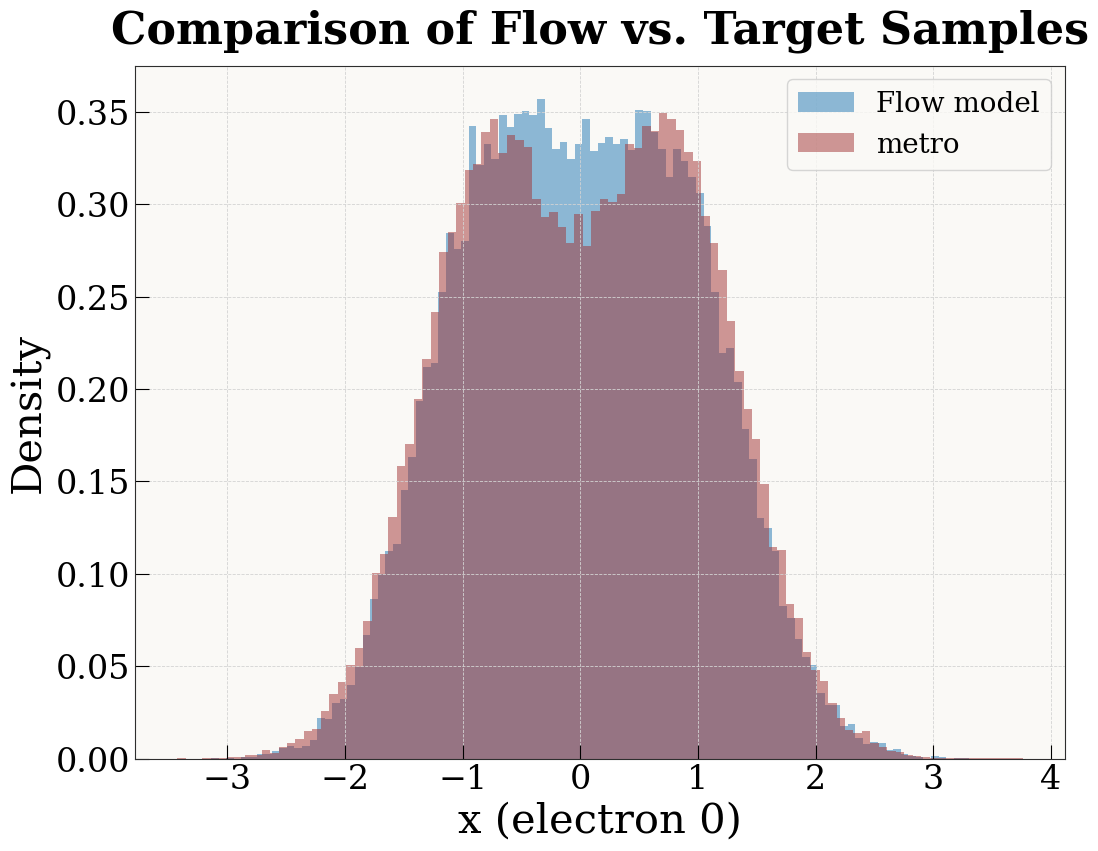

In [16]:
x = sample(Mapper, 40000).detach().cpu().numpy()
x_target_plot=x_target_plot.cpu()
plt.figure()
plt.hist(x[:,0], bins=100, density=True, alpha=0.5, label="Flow model")
plt.hist(x_target_plot[:,0,0], bins=100, density=True, alpha=0.5, label="metro")
plt.xlabel("x (electron 0)")
plt.ylabel("Density")
plt.legend()
plt.title("Comparison of Flow vs. Target Samples")
plt.show()

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Training The wavefunction</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   We are now ready to define and train the wavefunction
</p>

In [17]:
class PINN(nn.Module):
    def __init__(self, n_particles, d, hidden_dim=100, n_layers=2, omega=1.0,r=0.1,act=nn.GELU(),dL=5,init='xavier'):
        """
        Constructs a network where the logarithm of the correlation factor is given by:
          sum_i phi(x_i) + sum_{i<j} psi(x_i, x_j)
        
        For the pairwise term, here we use (x_i - x_j)^2 as input (element-wise).
        
        Args:
            n_particles (int): Number of particles.
            d (int): Dimension per particle.
            hidden_dim (int): Hidden layer size for sub-networks.
            n_layers (int): Number of hidden layers for each sub-network.
            act (nn.Module): Activation function.
        """
        super(PINN, self).__init__()
        self.idx_i, self.idx_j = torch.triu_indices(n_particles,n_particles, offset=1)  # shape (2, P)
        self.n_particles = n_particles
        self.d = d
        self.dL = dL
        self.r=r
        self.omega = omega
        # Build the per-particle network φ: maps d -> 1.
        self.phi = self.build_mlp(in_dim=d, hidden_dim=hidden_dim, out_dim=dL, n_layers=n_layers, act=act)
        self.psi = self.build_mlp(in_dim=1, hidden_dim=hidden_dim, out_dim=dL, n_layers=n_layers, act=act)
        self.rho = self.build_mlp(in_dim=dL*2, hidden_dim=hidden_dim, out_dim=1, n_layers=n_layers, act=act)
        # Apply Kaiming (He) initialization to every Linear layer.
        self._initialize_weights(init)
    
    def build_mlp(self, in_dim, hidden_dim, out_dim, n_layers, act):
        """
        Build a multi-layer perceptron (MLP).
        Args:
            in_dim (int): Input dimension.
            hidden_dim (int): Hidden layer size.
            out_dim (int): Output dimension.
            n_layers (int): Number of hidden layers (excluding the first and final Linear layers).
            act (nn.Module): Activation function.
        
        Returns:
            nn.Sequential: The constructed MLP.
        """
        layers = []
        # First layer: in_dim -> hidden_dim.
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(act)
        # Additional hidden layers.
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(act)
        # Final output layer: hidden_dim -> out_dim.
        layers.append(nn.Linear(hidden_dim, out_dim))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self,scheme):
        # 1) GELU moments under N(0,1)
        g0_sq, g1_sq = 0.1580, 0.4553
        g2_sq, g3_sq = 0.2769, 0.2962
        
        # 2) physics weights
        r = self.r  # kinetic_frac = <K>/(<V_trap>+<V_int>)
        total = 1 + 3*r
        a0 = r     / total  # raw-output (0th)
        a1 = 1.0   / total  # first derivative
        a2 = r     / total  # second derivative
        a3 = r     / total  # third derivative
    
        for m in self.modules():
                if scheme == "custom":
                    gain = 1.13  # ≈1/√0.1580 for GELU
                    for m in self.modules():
                        if isinstance(m, nn.Linear):
                            nn.init.xavier_normal_(m.weight, gain=gain)
                            nn.init.zeros_(m.bias)
                elif scheme == 'xavier':
                    for m in self.modules():
                        if isinstance(m, nn.Linear):
                            nn.init.xavier_normal_(m.weight)
                            nn.init.zeros_(m.bias)
                elif scheme == 'he':
                    for m in self.modules():
                        if isinstance(m, nn.Linear):
                            nn.init.kaiming_normal_(m.weight, mode='fan_in')
                            nn.init.zeros_(m.bias)
                # (you can remove 'lecun' if not used)
                elif scheme == 'lecun':
                    for m in self.modules():
                        if isinstance(m, nn.Linear):
                            nn.init.kaiming_normal_(m.weight, mode='fan_in',nonlinearity='linear')
                            nn.init.zeros_(m.bias)
                else:
                    raise ValueError(f"Unknown init scheme {scheme}")

                # Always zero out biases
                nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        Compute the logarithm of the correlation factor.
        
        Args:
            x (torch.Tensor): Input of shape (batch, n_particles, d).
        
        Returns:
            torch.Tensor: Output of shape (batch, 1) representing log(Ψ_corr),
                          so that the full wavefunction is given by
                          Ψ(x) = SD(x) * exp(f(x)).
        """
        batch, n, d = x.shape
    
        # 1) φ-branch: apply φ to each particle, then average across particles.
        #    φ expects input shape (batch * n_particles, d) -> outputs (batch*n, dL)
        phi_flat = x.view(-1, d)                           # (batch*n, d)
        phi_out = self.phi(phi_flat)                       # (batch*n, dL)
        phi_out = phi_out.view(batch, n, -1)               # (batch, n, dL)
        phi_mean = phi_out.mean(dim=1)                     # (batch, dL)
    
        # 2) Pairwise ψ-branch: compute all pairwise distances in one call.

        diff = x.unsqueeze(2) - x.unsqueeze(1)
        # Select only i<j pairs: (batch, num_pairs, d)
        diff_pairs = diff[:, self.idx_i, self.idx_j, :]  # (batch, P, d)
        r_ij = diff_pairs.norm(dim=-1, keepdim=True)
        psi_in = r_ij.view(-1, 1)                      # (batch*P, 1)
        psi_out = self.psi(psi_in)                     # (batch*P, k)
        psi_out = psi_out.view(batch, -1, self.dL)      # (batch, P, k)
        psi_sum = psi_out.sum(dim=1)                   # (batch, k)

        # --- Combine and finalize ---
        rho_in = torch.cat([phi_mean, psi_sum], dim=1) # (batch, dL + k)
        out = self.rho(rho_in)                         # (batch, 1)
        return out


In [18]:
def solve_sigma(A0, A1, init=0.1):
    """
    Solve for s=sigma^2 minimizing J(s) = (e^{A0 s}A0 s -1)^2 + (e^{A0 s}A1 s -1)^2
    via a couple iterations of Newton's method.
    """
    s = init
    for _ in range(10):
        expA0s = math.exp(A0*s)
        F = expA0s * A0*s
        B = expA0s * A1*s
        # dF/ds and dB/ds
        dF = expA0s*(A0 + A0*A0*s)
        dB = expA0s*(A1 + A0*A1*s)
        # J and its derivative
        J  = (F-1)**2 + (B-1)**2
        dJ = 2*(F-1)*dF + 2*(B-1)*dB
        s  = s - J/dJ
        if abs(J) < 1e-6:
            break
    return s

In [19]:
Vs = [20]
Es = [2.6057]
n_epochs = 500
N_collocation = 1000
hidden_dim = 200
n_hidden = 2
learning_rate=1e-3
# Activation functions
activation_functions = {
    "GELU": nn.GELU()
}

In [20]:
def train_model(V, E, f_net, optimizer, N_collocation=200, n_epochs=800, step_size=0.1, device=device):
    """
    Train the model as a PINN by minimizing the PDE residual and enforcing normalization.
    (This function is kept unchanged.)
    """
    factor = 1e-3
    f_net.to(device)
    Mapper.to(device)
    Energies = []
    Energies_std = []
    for epoch in range(n_epochs):
        x = sample(Mapper, N_collocation).unsqueeze(-1)*1.3
        optimizer.zero_grad()
        SD = slater_determinant_from_C_occ_batch(x, C_occ, device=device)
        # f_net(x) returns log-correlation; exponentiate it.
        f_out = torch.exp(f_net(x))
        psi = SD * f_out
        #norm = torch.norm(psi, p=2)
        norm = torch.norm(psi, p=2)
        psi = psi / norm
        laplacian = compute_laplacian_fast(psi_fn, x)
        V_harmonic = 0.5 * (x ** 2).sum(dim=(1, 2)).view(-1, 1)
        V_int = compute_interaction_potential(x, V, 0.5)
        V_total = V_harmonic + V_int
        H_psi = -0.5 * laplacian + V_total * psi
        residual = H_psi - E * psi
        norm_loss = (norm - 1) ** 2
        loss_pde = torch.mean((residual) ** 2)
        variance = torch.var(H_psi / psi)
        loss = loss_pde + factor * norm_loss
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            Energy, STD = compute_energy(f_net, V=V, n_samples=int(1e4 * 2), L=5, device=device)
            Energies.append(Energy)
            Energies_std.append(STD)
            print(f"Epoch {epoch:05d}: PDE Loss = {loss_pde.item():.3e}, Norm = {norm.item():.3e}, Variance = {variance.item():.3e}, Energy = {Energy:.6f}")
    return f_net, Energies, Energies_std

In [22]:
f_net = PINN(n_particles=n_particles, d=d, hidden_dim=hidden_dim, n_layers=n_hidden, act=nn.GELU(),init='custom').to(device)
optimizer = optim.Adam(f_net.parameters(), lr=learning_rate)

f_net, es, es_std = train_model(V=Vs[0], E=Es[0], f_net=f_net,
                                            optimizer=optimizer, N_collocation=N_collocation,
                                            n_epochs=n_epochs, device=device)

Epoch 00009: PDE Loss = 6.590e-02, Norm = 2.638e+00, Variance = 8.243e+02, Energy = 5.444353
Epoch 00019: PDE Loss = 1.552e-02, Norm = 1.293e+00, Variance = 3.653e+01, Energy = 4.295180
Epoch 00029: PDE Loss = 3.664e-03, Norm = 4.986e-01, Variance = 1.480e+01, Energy = 3.191711
Epoch 00039: PDE Loss = 1.180e-03, Norm = 5.849e-01, Variance = 2.671e+01, Energy = 3.021583
Epoch 00049: PDE Loss = 5.975e-04, Norm = 1.294e+00, Variance = 3.739e+03, Energy = 3.178268
Epoch 00059: PDE Loss = 5.396e-04, Norm = 9.937e-01, Variance = 1.915e+04, Energy = 2.909805
Epoch 00069: PDE Loss = 2.886e-04, Norm = 1.177e+00, Variance = 2.814e+03, Energy = 2.766870
Epoch 00079: PDE Loss = 2.416e-04, Norm = 1.157e+00, Variance = 6.781e+03, Energy = 2.698043
Epoch 00089: PDE Loss = 2.466e-04, Norm = 1.066e+00, Variance = 6.765e+02, Energy = 2.678751
Epoch 00099: PDE Loss = 1.479e-04, Norm = 1.137e+00, Variance = 2.162e+02, Energy = 2.671514
Epoch 00109: PDE Loss = 1.337e-04, Norm = 1.099e+00, Variance = 4.302e

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Plotting generated data</h2>

<p style="font-family:Times New Roman; font-size:120%">    
   The rest of the notebook is used only for generating plots for the paper, I include it here for completeness.
</p>

In [ ]:
colors = {
    #"Mish": '#1f77b4',
    #"Tanh": '#a13333',
    #"Sigmoid": '#8c564b',
    #"SiLU": '#2ca02c',
    "GELU": '#1f77b4'
}

In [ ]:
# ------------------- Configuration -------------------
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset


Vs = [10,20]
Es = [2.4256, 2.6057]
Es_ci = Es
act = "GELU"

colors = {
    1: '#1f77b4',
    2: '#a13333',
    3: '#8c564b',
}

# Extract training epoch axis
sample_V = Vs[0]
sample_energy = results[1][sample_V]["GELU"]["energies"]
epochs = np.linspace(0, 500, len(sample_energy))
n_epochs = len(epochs)
zoom_start = int(0.9 * n_epochs)
zoom_epochs = epochs[zoom_start:]
zoom_xmin, zoom_xmax = zoom_epochs[0], zoom_epochs[-1]

# Convergence threshold for insets
epsilon = 0.3
n_epochs=n_epochs*10
# ------------------- Plotting Setup -------------------
fig, axs = plt.subplots(2, 1, figsize=(28, 20), sharex=True)
axs = axs.flatten()

def plot_with_std(ax, x, y, std, label, color):
    ax.plot(x, y, label=label, color=color, linewidth=3.4)
    ax.fill_between(x, y - std, y + std, alpha=0.2, color=color)

    # ------------------- Main Loop -------------------
for i, (V, E_ci) in enumerate(zip(Vs, Es)):
    ax = axs[i]
    final_energies = {}

    # --- Full curve plot ---
    for hid in range(1,4):
        energy = results[hid][V][act]["energies"]
        std = results[hid][V][act]["std"]
        if hid==1:
            plot_with_std(ax, epochs, energy, std, f"{hid}-layer", colors[hid])
        else:
            plot_with_std(ax, epochs, energy, std, f"{hid}-layers", colors[hid])
        final_energies[hid] = energy[-1]

    ax.axhline(y=E_ci, color='black', linestyle='dashdot', linewidth=2.0, label="CI")
    ax.text(0.45, 0.95, f"$V_0 = {V}$", fontsize=46, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(facecolor='#faf9f6', alpha=0.8, edgecolor='none'))

    #ax.text(0.45, 0.95, f"$V_0 = {V}$", fontsize=36, transform=ax.transAxes, verticalalignment='top')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Energy")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=7))
    # --- Zoomed Inset ---
    axins = inset_axes(ax, width="35%", height="35%", loc='upper right',
                       bbox_to_anchor=(0.05, -0.05, 0.95, 0.95),
                       bbox_transform=ax.transAxes, borderpad=2)

    # Get activations that converge
    converged_hids = [hid for hid in range(1,4) if (abs(final_energies[hid] - E_ci)<epsilon) or (final_energies[hid]<E_ci)]

    # Collect y-values for zoom range (including E_ci)
    zoom_yvals = []
    for h in converged_hids:
        energy = results[h][V][act]["energies"][zoom_start:]
        zoom_yvals.append(energy)
    zoom_yvals = np.concatenate(zoom_yvals) if zoom_yvals else np.array([])
    zoom_yvals = np.append(zoom_yvals, E_ci)

    ymin, ymax = zoom_yvals.min(), zoom_yvals.max()
    pad = 0.05 * max(ymax - ymin, 1e-4)

    # Plot converged models only in inset
    for hid in range(1,4):
        energy = results[hid][V][act]["energies"]
        std = results[hid][V][act]["std"]
        plot_with_std(axins, epochs, energy, std, act, colors[hid])

    # Always draw E_ci line
    axins.axhline(y=E_ci, color='black', linestyle='dashdot', linewidth=2)

    # Inset formatting
    axins.set_xlim(zoom_xmin, zoom_xmax)
    axins.set_ylim(ymin - pad, ymax + pad)
    axins.tick_params(labelsize=24)
    axins.grid(True, linestyle='--', alpha=0.8)
    axins.set_title("Zoom in", fontsize=30,
         bbox=dict(facecolor='#faf9f6', alpha=0., edgecolor='none'))

    # Ghost box
    mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="k", linestyle="--", linewidth=2,alpha=0.8)
    for label in axins.get_xticklabels() + axins.get_yticklabels():
        label.set_backgroundcolor("#faf9f6")
        label.set_alpha(0.9)


# ------------------- Final Layout -------------------
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.01),
           ncol=6, frameon=False, fontsize=44)

plt.tight_layout(rect=[0, 0, 1, 0.96])
#save_path = base_folder / f"Results_{n_particles}p.pdf"
plt.savefig("Results_2p_hidden", bbox_inches='tight')
plt.show()